In [52]:
%matplotlib inline

In [53]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import librosa as lb
import librosa.display as lbd
import IPython.display as ipd
import scipy.signal as ss
import scipy.spatial as sspat
import scipy.fft as sfft
import warnings
import pickle as pkl
import time

In [3]:
%cd ../
import DTW
import TSM_Import

/mnt/c/Users/Daniel Yang/Desktop/Final_Project


# Import Data and Hyperparameter

In [4]:
fileId_path = "experiments/fileIds.pkl"
queryInfo_path = "experiments/queryInfo.pkl"
timeData_path = "experiments/timeData.pkl"
audioFiles_path = "experiments/audioFiles.pkl"
with open(fileId_path, 'rb') as f:
    fileIds=pkl.load(f)
with open(queryInfo_path, 'rb') as f:
    queryInfo=pkl.load(f)
with open(timeData_path, 'rb') as f:
    timeData=pkl.load(f)
with open(audioFiles_path, 'rb') as f:
    audioFiles=pkl.load(f)

# Segmental DTW

## Feature Extraction

In [54]:
def getChromaFeatures(audio, hop_length=512, sr=22050):
  chroma = lb.feature.chroma_stft(y=audio, norm=2, hop_length=hop_length)
  return chroma

## Segmental DTW

In [55]:
def getCostMatrices(queries, ref):
  cost_matrices = []
  for query_chroma in queries:
    cost_matrices.append(sspat.distance.cdist(query_chroma.T, ref.T, metric='cosine'))
  return cost_matrices


In [56]:
def getAccumCostMatrix(cost_matrix):
  steps = np.array([2, 1, 1, 2, 1, 1]).reshape((-1,2))
  weights = [2,1,1]
  D = lb.sequence.dtw(C=cost_matrix, step_sizes_sigma=steps, weights_mul=weights, subseq=True, backtrack=False)
  return D

In [57]:
def local_backtrace(D, C, endpoint):
    '''
    Backtraces through the cumulative cost matrix D.
    
    Arguments:
    D -- cumulative cost matrix
    B -- backtrace matrix
    steps -- a numpy matrix specifying the allowable transitions.  It should be of
            dimension (L, 2), where each row specifies (row step, col step)
    
    Returns:
    path -- a python list of (row, col) coordinates for the optimal path.
    '''

    path = []
    steps = np.array([2, 1, 1, 2, 1, 1]).reshape((-1,2))
    weights = [2,1,1]

    ### START CODE BLOCK ###
    r = C.shape[0]-1
    c = endpoint
    path = []
    while r!=0:
        path.append((r,c))
        for idx,step in enumerate(steps):
          prev_r = r - step[0] 
          prev_c = c - step[1]
          cost = C[r,c]
          accum_cost = D[r,c]
          prev_cell = D[prev_r,prev_c]
          if np.abs(prev_cell+cost*weights[idx]-accum_cost)<0.000001:
            r = prev_r
            c = prev_c
            break 
        
        if r==0:
          path.append((r,c))
    ### END CODE BLOCK ###
    
    return path

In [58]:
def generateSegmentCostMatrix(costMatrices):
  frame_cost_matrix = []
  for D in costMatrices:
    cost = D[-1,:]
    frame_cost_matrix.append(cost)
  return frame_cost_matrix

In [59]:
def segmental_DTW(segmentCostMatrix, segment_lengths):
  steps = [[0,1]]
  weights = [0.1]
  D, path = DTW.globalDTW(segmentCostMatrix, steps, weights, segment_lengths)

  return D, path

In [60]:
def getPathEnds(global_path, C0):
  endpoints = []
  for idx in range(1,len(global_path)):
    if global_path[idx][0]!=global_path[idx-1][0]:
      endpoints.append(global_path[idx])
  endpoints.insert(0,(0,np.argmin(C0)))
  return endpoints


## TSM

In [61]:
def extrapolateTimeStretchFunction(local_paths, N, hop_length):
  new_stretch = []
  k = 0
  slope = 1
  new_time = 0
  counter = 0
  for i in range(0,N):
    if k<len(local_paths) and i >= local_paths[k][0][1]*hop_length and i <= local_paths[k][-1][1]*hop_length:
      path = local_paths[k]
      if i == path[-1][1]*hop_length:   
        k+=1
        slope=1
        counter = 0
      elif i == path[counter][1]*hop_length:
        slope = (path[counter+1][0]-path[counter][0])/(path[counter+1][1]-path[counter][1])
        counter+=1
    else:
      slope=1
    new_time+=slope
    new_stretch.append(int(new_time))
  return new_stretch
def getInverseTimeFunction(time_function):
  inverse_function = []
  counter = 0
  for i in range(int(time_function[-1]+1)):
    while time_function[counter]<i:
      counter+=1
    inverse_function.append(counter)
  return inverse_function

In [63]:
def tf_preprocessing(local_paths):
    ls = []
    for seg in local_paths:
        new_seg = []
        for pair in seg:
            new_seg.append(np.array([pair[0],pair[1]]))
        ls.append(np.array(new_seg))
    return ls


    return output


In [ ]:
def seg_time_function(wp, hop_length):
    start_time  = time.time()
    wp = wp*hop_length
    output = np.zeros((wp[-1,1]-wp[0,1])+1)
    x_b = wp[0,1]
    for pair_index in range(len(wp)-1):
        y_0 = wp[pair_index,0]
        y_1 = wp[pair_index+1,0]
        x_0 = wp[pair_index,1]
        x_1 = wp[pair_index+1,1]
        slope = (y_1-y_0)/(x_1-x_0)
        array = y_0+np.arange(x_1-x_0)*slope
        output[x_0-x_b:x_1-x_b] = array
    output[-1] = wp[-1,0]

In [ ]:
def group_time_function(wp,ref_audio_len, hop_length=512):
    wp = tf_preprocessing(wp)
    start_time = time.time()

    output = np.zeros(ref_audio_len)
    

    current_start = 0
    for index, seg_path in enumerate(wp):

        pre_padd_end = seg_path[0][1] * hop_length

        output[current_start:pre_padd_end]=(np.arange(pre_padd_end-current_start)+1)+output[current_start-1]

        current_start = pre_padd_end
        tf = seg_time_function(seg_path,hop_length)
        if index > 0:
            start_point = max(0,wp[index-1][-1][1]-wp[index][0][1])*hop_length
            end_point = min(len(output)-current_start,len(tf))

            tf = tf[start_point:end_point]

        if len(tf)>=2:
            output[current_start:current_start+len(tf)] = tf+tf[1]+output[current_start-1]
        elif len(tf)==1:
            output[current_start:current_start+len(tf)] = tf+output[current_start-1]
        current_start = current_start+len(tf)

    output[current_start:]=np.arange(ref_audio_len-current_start)+output[current_start-1]
    return output

## Process Queries

In [62]:
def writeToFile(tf, segment_predict, solo_name, ref_name, hypdir, time_taken):
    if hypdir != None:
        experiment = "experiments/{}".format(hypdir)
        if not os.path.exists(experiment):
            os.mkdir(experiment)
        fname = "experiments/{}/{}-{}.hyp".format(hypdir,solo_name,ref_name)
        with open (fname, 'wb') as f:
            pkl.dump((solo_name, ref_name, tf, segment_predict, time_taken),f)

In [353]:
def processQuery(solo_name, ref_name, hop_length, visualize=False, hypdir = None, sr=22050):
  print("Processing solo {}, Accompaniment {}".format(solo_name, ref_name))
  start_time = time.time()
  outfile = 'experiments/{}/{}-{}.hyp'.format(hypdir, solo_name, ref_name)
  if os.path.exists(outfile) and visualize == False:
    print("Skipped: {}".format(outfile))
    return None

  solo_segments = audioFiles[solo_name]
  ref_audio = audioFiles[ref_name]


  # Calculate L2-Normalized Chromas
  solo_chromas = []
  segment_lengths = []
  ref_chroma = getChromaFeatures(ref_audio, hop_length)
  
  for i in solo_segments:
    solo_chromas.append(getChromaFeatures(i))
    segment_lengths.append(solo_chromas[-1].shape[1])
    
  # Frame-Level DTW
  frame_costs = []
  accum_costs = []
  cost_matrices = getCostMatrices(solo_chromas, ref_chroma)
  for C in cost_matrices:
    D = getAccumCostMatrix(C)
    accum_costs.append(D)
  print(time.time()-start_time)
    
  
  # Segment-Level DTW
  segment_cost = np.array(generateSegmentCostMatrix(accum_costs))
  D, path = segmental_DTW(segment_cost, segment_lengths)
  pathEnds = getPathEnds(path[::-1],segment_cost[0])
  if visualize:
      lbd.specshow(D, x_axis='frames', y_axis='frames')
      x = [i[0] for i in path]
      y = [i[1] for i in path]
      plt.plot(y, x, label='Optimal path', color='y')
      keys = queryInfo[solo_name.split('_')[0]]
      samples = []
      for idx,key in enumerate(keys):
          i = key.split(',')[1][:-1]
          plot_time = timeData[ref_name][i]
          sample = np.round(plot_time*sr/hop_length)
          plt.plot(int(sample), idx, marker=".", markersize=16)

  # Local Backtraces
  local_paths = []
  segment_predict = []
  for idx, C in enumerate(cost_matrices):
    local_path = list(local_backtrace(accum_costs[idx],C,pathEnds[idx][1]))[::-1]
    local_paths.append(local_path)
    segment_predict.append((local_path[0][1],pathEnds[idx][1]))
    
  # TSM
  time_function = extrapolateTimeStretchFunction(local_paths, len(ref_audio), hop_length)
  time_taken = time.time()-start_time
  print("Took {} seconds".format(time_taken))
  writeToFile(time_function, segment_predict, solo_name, ref_name, hypdir, time_taken)
  return time_function, local_paths, segment_cost,D, segment_predict, solo_chromas, accum_costs, solo_segments, ref_audio

Processing solo p1s_perf12, Accompaniment p1f_perf2
6.250391006469727
Took 15.552380561828613 seconds


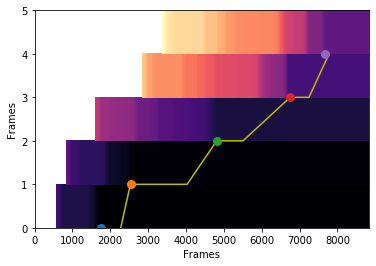

In [354]:
# Process 1 Query
solo_name, ref_name ='p1s_perf12','p1f_perf2'
time_function, local_paths,sc,D, sp, solo_chromas, ac,ss, ra  = processQuery(solo_name, ref_name, hop_length=512, visualize=True, hypdir="debug4")

In [ ]:
# Process all queries
multiprocess = False
hypdir = "expTest8"
solo = {}
accompaniment = {}
for fileId in fileIds:
    pieceNum = fileId.split("_")[0]
    if 's' in fileId:
        if not pieceNum in solo.keys():
            solo[pieceNum] = [fileId]
        else:
            solo[pieceNum].append(fileId)
    if 'f' in fileId:
        if not pieceNum in accompaniment.keys():
            accompaniment[pieceNum] = [fileId]
        else:
            accompaniment[pieceNum].append(fileId)
inputs = []
for piece in solo.keys():
    soloPieces = solo[piece]
    refPieces = accompaniment[piece[:-1]+'f']
    for i in soloPieces:
        for j in refPieces:
            inputs.append([i,j,512, False, hypdir])

if multiprocess: 
    n_cores = multiprocessing.cpu_count()-1
    pool = multiprocessing.Pool(processes=n_cores)
    outputs = list(pool.starmap(processQuery, inputs))
else:
    for i in inputs:
        processQuery(i[0], i[1], i[2], i[3], i[4])

# Generate Audio

In [342]:
time_function1 = getInverseTimeFunction(time_function)
new_audio = TSM_Import.phase_vocoder(audio,time_function1)

w nom (1025, 1) hop (2484,) S (1025, 2484) analysis_instances (2488,) S[0] (2484,)


In [343]:
ipd.Audio(new_audio, rate = 22050)